# H&M Fashion search engine with Weaviate and DocArray

In this notebook, we use [DocArray](https://docarray.jina.ai/) and with the vector DB [Weaviate](https://weaviate.io/) to show how you can set up a simple similar image search. 

If you have questions or let us know your feedback, please join the [Weaviate Slack channel](https://join.slack.com/t/weaviate/shared_invite/zt-goaoifjr-o8FuVz9b1HLzhlUfyfddhw)!

## 0. Install libraries

In [43]:
!pip install docarray[full]
!pip install torchvision==0.11.2

zsh:1: no matches found: docarray[full]


## 1. Importing libraries

In [44]:
from docarray import Document, DocumentArray

## 2. Configuration and setup

We'll set up some basic variables. Feel free to adapt these for your own project!

There is some sample data included in this repository. If you want to use the demo with the full H&M Fashion image dataset, follow the steps in the Readme to download the images from the [Kaggle competition](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/data).

The images in the sample dataset are already scaled down to 80x60 to limit the file size.

In [45]:
MAX_DOCS = 10000
DATA_DIR = 'sample_data'
DATA_PATH = f"{DATA_DIR}/**/*.jpg"
QUERY_IMAGE = "sample_data/012/0120129025.jpg"

Now we initiate the vector storage of the images, using Weaviate. You need to have a Weaviate instance running on `http://localhost:8080`. You can do that by running `docker compose up` in the terminal in this folder, using the `docker-compose.yml` file. 
Alternatively, you can start a Weaviate instance for free with [WCS: Weaviate Cloud Service](https://console.semi.technology/). 

DocArray supports Weaviate as a storage backend, one can use it as the follows:

In [46]:
DocumentArray(storage='weaviate', config={'host': 'localhost', 'port': 8080, 'name': 'Image'}).summary()

       Documents Summary        
                                
  Length                 0      
  Homogenous Documents   False  
                                
           Storage Summary            
                                      
  Backend                  Weaviate   
  Host                     localhost  
  Port                     8080       
  Protocol                 http       
  Schema Name              Image      
  Serialization Protocol

The look-and-feel of a weaviate-powered DocumentArray is exactly the same as an ordinary DocumentArray. All APIs behave the same. We will see that in the sequel.

## 3. Load Data

Now that all is set up, we can start adding the fashion images to the database. 

In [47]:
docs = DocumentArray.from_files(DATA_PATH, size=MAX_DOCS, storage='weaviate', config={'host': 'localhost', 'port': '8080', 'name': 'Image'})

print(f"{len(docs)} Documents in DocumentArray")


1000 Documents in DocumentArray


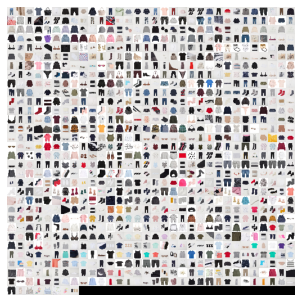

In [48]:
docs.plot_image_sprites() # Preview the images

## 4. Preprocess Data

In [49]:
# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

In [50]:
# apply en masse
docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 1000                                  
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       1000             False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   1000             False            
  uri         ('str',)       1000             False            
                                                               
           Storage Summary            
                                      
  Backend                  Weaviate   
  Host                     localhost  
  Port                     8080       
  Protocol                 http       
  Schema Name              Image      
  Serialization Protocol

## 5. Embed images

Using GPU is recommended when you want to do image search on large scale. 

In [51]:
# Use GPU if available
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

We use the ResNet50 model to embed our images. 

In [52]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

In [53]:
docs.embed(model, device=device, batch_size=20)

                             Documents Summary                              
                                                                            
  Length                 1000                                               
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    1000             False            
  id          ('str',)       1000             False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   1000             False            
  uri         ('str',)       1000             False            
                                                               
           Storage Summary            
                                      
  Backend                  Weaviate   
  Host                     localhost  
  Port                     8080       
  Protocol                 http       
  Schema Name              Image      
  Serialization Protocol

We can remove the tensor of the images to reduce remory usage. This will significantly improve the speed of the `.find()` operation below.

In [54]:
docs[:, 'tensor'] = None

## 6. Query dataset

Let's query the dataset with one of the images of the dataset. We've stored this in `data/query.jpg`. Feel free to choose any jpg image of clothing as query image.

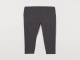

In [55]:
query_doc = Document(uri=QUERY_IMAGE)
query_doc.display()

In [56]:
query_doc = preproc(query_doc)

In [57]:
query_doc.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

 <Document ('id', 'tensor', 'mime_type', 'uri', 'embedding') at 1df08f1a9ec511ecb1f0acde48001122>


In [58]:
top10 = docs.find(query_doc, limit=10)

Show the result:

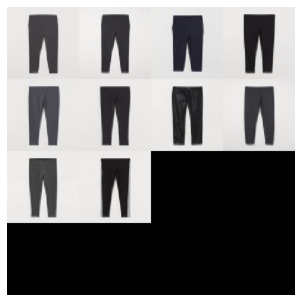

In [59]:
top10.plot_image_sprites(image_source='uri')

That's it! You can change the example query image and try out more searches yourself.